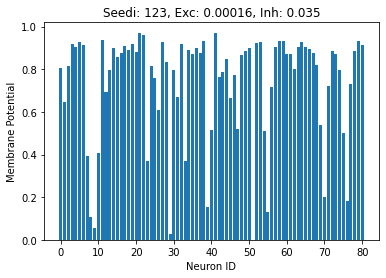

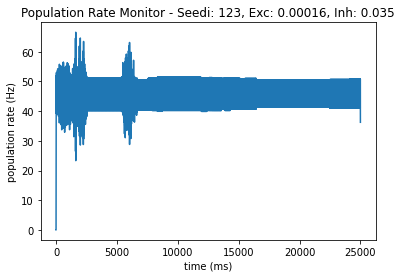

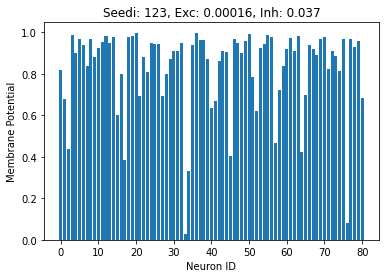

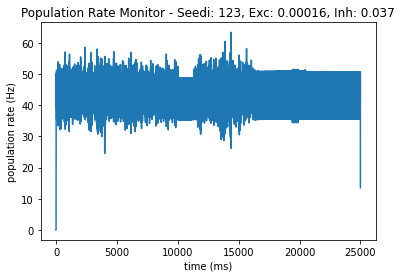

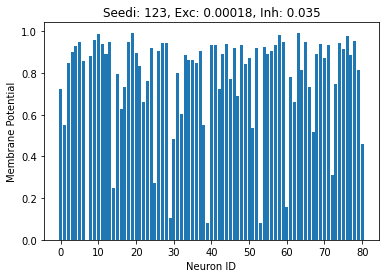

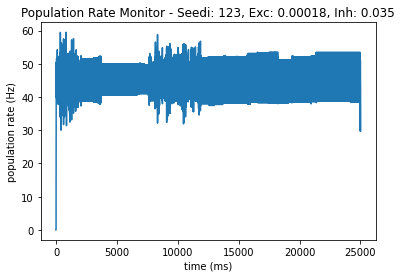

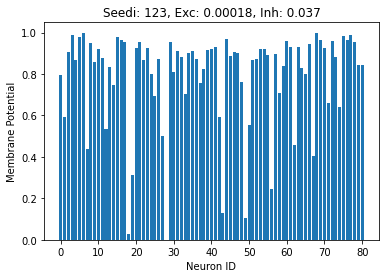

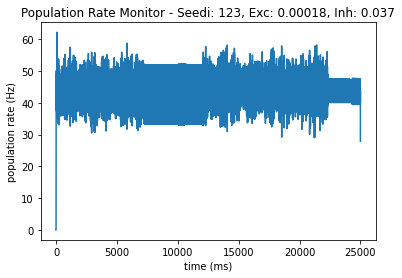

In [3]:
from brian2 import *
from brian2tools import *
import numpy as np
import copy
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Constants
tau = 4*ms
I = (1.1)/ms
gamma = 1/ms

# Non-dimensionalized constants
tp = tau/ms
curr = I*ms
g = gamma*ms
out = curr/g  # should be > the threshold of firing

# Equation (2)
eqs2 = '''
dv/dt = ((I/gamma) - v + sin(2*pi*0.00000001*t/ms))/tau : 1
i_count : 1
e_count : 1
'''

# Function to run the simulation
def run_simulation(seedi, exc, inh, save_path):
    start_scope()
    np.random.seed(seedi)

    # Initialize the neuron group
    n = 81
    G1 = NeuronGroup(n, eqs2, threshold='v>1', reset='v = 0', method='euler')
    groupinit = np.random.uniform(0.1, 0.9, n)
    G1.v = groupinit

    sudo = G1.i[:].reshape(9, 9)

    subgrids = [[(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)],  # 0
                [(0,3),(0,4),(0,5),(1,3),(1,4),(1,5),(2,3),(2,4),(2,5)],  # 1
                [(0,6),(0,7),(0,8),(1,6),(1,7),(1,8),(2,6),(2,7),(2,8)],  # 2
                [(3,0),(3,1),(3,2),(4,0),(4,1),(4,2),(5,0),(5,1),(5,2)],  # 3
                [(3,3),(3,4),(3,5),(4,3),(4,4),(4,5),(5,3),(5,4),(5,5)],  # 4
                [(3,6),(3,7),(3,8),(4,6),(4,7),(4,8),(5,6),(5,7),(5,8)],  # 5
                [(6,0),(6,1),(6,2),(7,0),(7,1),(7,2),(8,0),(8,1),(8,2)],  # 6
                [(6,3),(6,4),(6,5),(7,3),(7,4),(7,5),(8,3),(8,4),(8,5)],  # 7
                [(6,6),(6,7),(6,8),(7,6),(7,7),(7,8),(8,6),(8,7),(8,8)]   # 8
                ]

    def getsubgrid(i,j):
        if i<3:
            if j<3:
                subgrid = 0
            if j>2 and j<6:
                subgrid = 1
            if j>5 and j<9:
                subgrid = 2
        elif i>2 and i<6:
            if j<3:
                subgrid = 3
            if j>2 and j<6:
                subgrid = 4
            if j>5 and j<9:
                subgrid = 5
        elif i>5 and i<9:
            if j<3:
                subgrid = 6
            if j>2 and j<6:
                subgrid = 7
            if j>5 and j<9:
                subgrid = 8
        return subgrids[subgrid]

    def matcon(i,j):
        matrix[i, j] = 1

    def connectrowcol(i,j):
        for y in range(9):
            if y == i:
                pass
            else:
                matcon(sudo[i,j], sudo[y,j])
        for x in range(9):
            if x == j:
                pass
            else:
                matcon(sudo[i,j], sudo[i,x])

    def connectsub(i,j):
        for (x,y) in getsubgrid(i,j):
            if (x,y) != (i,j):
                matcon(sudo[i,j], sudo[x,y])

    def inhibconnect():
        for i in range(9):
            for j in range(9):
                connectrowcol(i,j)
                connectsub(i,j)

    matrix = np.zeros((n, n))
    inhibconnect()

    exc_matrix = 1 - matrix

    si, ti = matrix.nonzero()
    se, te = exc_matrix.nonzero()

    # Inhibitory synapses
    I1 = Synapses(G1, G1, on_pre='''v = v - inh''')

    # Excitatory synapses
    E1 = Synapses(G1, G1, on_pre='''v = v + exc''')

    I1.connect(i=si, j=ti, p=1)
    E1.connect(i=se, j=te)

    M1 = StateMonitor(G1,'v', record=True)
    Sp1 = SpikeMonitor(G1)
    rate_mon = PopulationRateMonitor(G1)

    run(25000*ms)

    final_membrane_potentials = M1.v[:, -1]
    neuron_ids = np.arange(81)

    # Save spike train data
    spike_train_filename = os.path.join(save_path, f"spike_train_seedi{seedi}_exc{exc}_inh{inh}.txt")
    with open(spike_train_filename, "w") as f:
        for neuron_id in range(81):
            spike_times = Sp1.t[Sp1.i == neuron_id] / ms
            spike_times_str = " ".join([str(st) for st in spike_times])
            f.write(f"{spike_times_str}\n")

    # Save population frequency data
    population_rate_filename = os.path.join(save_path, f"population_rate_seedi{seedi}_exc{exc}_inh{inh}.txt")
    np.savetxt(population_rate_filename, np.array([rate_mon.t/ms, rate_mon.rate]).T, fmt='%0.4f', delimiter='\t', header='Time (ms)\tRate')

    return neuron_ids, final_membrane_potentials, rate_mon

# Define parameter sets
seedis = [123]
exc_values = [0.00016, 0.00018]
inh_values = [0.035, 0.037]

# Create a directory to save the data
save_path = "simulation_data"
os.makedirs(save_path, exist_ok=True)

# Run simulations
results = []

for seedi in seedis:
    for exc in exc_values:
        for inh in inh_values:
            neuron_ids, final_membrane_potentials, rate_mon = run_simulation(seedi, exc, inh, save_path)
            results.append((seedi, exc, inh, final_membrane_potentials, rate_mon))

# Plot results
for seedi, exc, inh, final_membrane_potentials, rate_mon in results:
    plt.figure()
    plt.bar(neuron_ids, final_membrane_potentials)
    plt.xlabel("Neuron ID")
    plt.ylabel("Membrane Potential")
    plt.title(f"Seedi: {seedi}, Exc: {exc}, Inh: {inh}")
    plt.show()

    brian_plot(rate_mon)
    plt.title(f"Population Rate Monitor - Seedi: {seedi}, Exc: {exc}, Inh: {inh}")
    plt.show()
